# Data access using the low-level API

In [1]:
import pandas as pd
import aeon.io.api as aeon
from aeon.analysis.utils import distancetravelled
from aeon.analysis.plotting import heatmap
from aeon.schema.schemas import social02
from aeon.metadata.social_02 import ExperimentMetadata
from matplotlib import pyplot as plt

The root path is the directory containing the entire dataset, including all epochs and chunks of data for all streams of all devices. If your local dataset is in a different location, please change the value below before running the cells below.

In [2]:
root = '/data/raw/AEON3/social0.2/'

## Experiment metadata

In [3]:
# read experiment metadata
metadata = aeon.load(root, social02.Metadata)['metadata'].iloc[0]
experiment = ExperimentMetadata(metadata)
arena = experiment.arena

## Position tracking

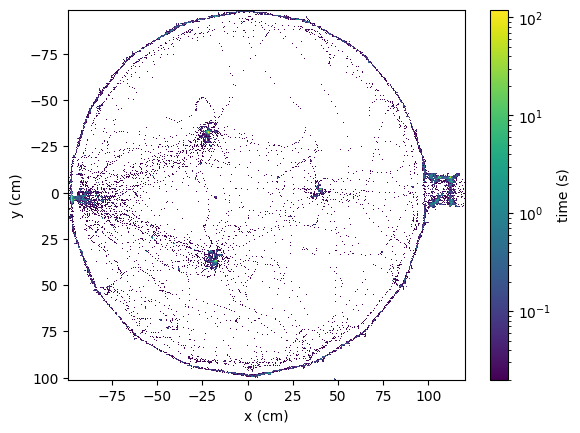

In [4]:
# read normalized position data
pose = aeon.load(root, social02.CameraTop.Pose)
position_cm = experiment.arena.point_to_cm(pose[['x', 'y']])

# plot position heatmap
fig, ax = plt.subplots(1, 1)
heatmap(position_cm, experiment.video.global_fps, bins=500, ax=ax)
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

## Foraging activity

In [23]:
patches = ["Patch1", "Patch2", "Patch3"]
patch_encoder = {patch: aeon.load(root, social02[patch].Encoder) for patch in patches}
patch_distance = {patch: distancetravelled(patch_encoder[patch].angle, radius=experiment.patch1.radius_cm / 100) for patch in patches}
pellet_deliveries = {patch: aeon.load(root, social02[patch].DepletionState).groupby(pd.Grouper(freq='1s')).first().dropna() for patch in patches}

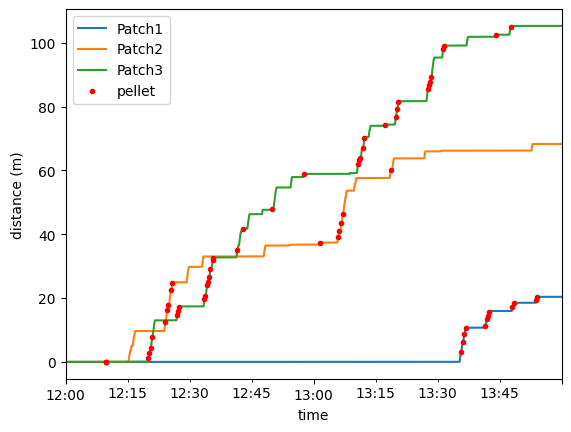

In [34]:
fig, ax = plt.subplots(1, 1)

for patch in patches:
    # plot distance travelled
    patch_distance[patch].plot(ax=ax, label=patch)

delivery_distance = pd.concat([
    pd.merge_asof(
        pellet_deliveries[patch],
        patch_distance[patch],
        left_index=True,
        right_index=True)
        for patch in patches])
delivery_distance.angle.plot(ax=ax, style='r.', label='pellet')
ax.set_ylabel('distance (m)')
ax.legend()
plt.show()


## Video analysis

In [8]:
video = {
    "CameraTop": aeon.load(root, social02.CameraTop.Video),
    "CameraPatch1": aeon.load(root, social02.CameraPatch1.Video),
    "CameraPatch2": aeon.load(root, social02.CameraPatch2.Video),
    "CameraPatch3": aeon.load(root, social02.CameraPatch3.Video),
    "CameraNest": aeon.load(root, social02.CameraNest.Video),
}